##**고객의 구매 패턴만 보고,**
##**앞으로 이 고객이 가져다 줄 매출을 예측할 수 있을까?**
---
#### **분석의 목적 :**

1. 고객들의 구매 데이터를 바탕으로, 고객이 어떤 특성을 갖고 있는지 분석하고
2. 고객별로 향후 n기간에 회사에 매출을 얼만큼 가져다 줄 지 예측하는 모델(RFM을 활용한 LTR class 예측을 중심으로)을 만들기 위함.
3. 얻은 인사이트를 활용하여 고객 집단별 마케팅전략을 짜는 데 기여할 수 있음.



#### **RFM**
<img src = 'https://860199.smushcdn.com/2079090/wp-content/uploads/predictive-segments-using-rfm-moengage-1-1.jpg?lossy=1&strip=1&webp=1' width="600"/>


마케팅분야에서 오랫동안 사용한 framework. 아래 3가지 기준을 바탕으로 고객을 분류하는 모델

* Recency(얼마나 최근에 결제했는가)
* Frequency(얼마나 자주 결제했는가)
* Monetary(얼마나 많은 금액을 결제했는가)

[참고 : 엑셀로 계산해보는 백화점 DM발송에 RFM을 활용한 사례](https://hujubkang.tistory.com/entry/RFM-analysis-Recency-Frequency-Monetary)


#### **LTV(LifeTime Value) & LTR(LifeTime Revenue)**
<img src='https://powerslides.com/wp-content/uploads/2021/01/Customer-Lifetime-Value-Template-2.jpg' width='700'>
<img src='https://sungmoon.files.wordpress.com/2011/11/screen-shot-2011-11-20-at-10-44-42-am.png' width='400'>



한명의 고객이 진입부터 이탈까지 전체 활동기간에 누적해서 발생시키는 기대수익을 LTV라고 한다. 

그러나 현업에서 LTV공식에 대입해 계산하는 데에는 어려움이 있다.


(i.e. 고객 1명을 획득할 때마다 드는 비용, 고객이 발생시키는 수익이 일정하지 않음,  고객유지비율이 일정하지 않음.) 

그래서 계산하기 어려운 LTV대신 약식으로 활용하는 지표가 LTR이며,

 LTR은 한명의 고객이 진입부터 이탈까지 전체 활동기간에 누적해서 발생시키는 '매출'로 계산할 수 있다.

[참고: Visualizations for Customer Lifetime Value](https://retina.ai/academy/lesson/visualizations-for-customer-lifetime-value/)

#### **PART1 : 필요한 라이브러리 import, 데이터를 가져와서 전처리(preprocessing) 하는 과정**

In [ ]:
%%capture
# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')
warnings.filterwarnings(action='ignore')

아래 셀을 실행하시려면, kaggle에서 받은 json형태의 API Token을 넣어주셔야 합니다. 

[Kaggle에서 데이터 다운로드 받는법 중 API Token을 받는 파트 참고](https://nomadcoder.tistory.com/entry/Kaggle-Kaggle-%EC%97%90%EC%84%9C-API%EB%A1%9C-%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B-%EB%8B%A4%EC%9A%B4%EB%B0%9B%EA%B8%B0)

In [ ]:
!pip install kneed
!pip install eli5
!pip install xgboost
!pip install --upgrade category_encoders
!pip install shap
!pip install pdpbox
!pip install kaggle

from google.colab import files
import pandas as pd
import numpy as np
import sklearn
import xgboost
import shap
from pandas_profiling import ProfileReport
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import silhouette_score, classification_report, accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score
from yellowbrick.cluster import SilhouetteVisualizer
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

shap.initjs();
# 데이터 불러오기 : kaggle에 있는 데이터를 다운로드할 API를 타기 위해 만든 Token 업로드하기 (filename : kaggle.json)
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 처리
!chmod 600 ~/.kaggle/kaggle.json
# 내가 쓰고자 하는 Online Retail Data set 불러오기
!kaggle datasets download -d vijayuv/onlineretail
# 파일 압축 해제
!unzip onlineretail.zip

# 데이터 불러오기
origin_df = pd.read_csv('OnlineRetail.csv', encoding='latin')
origin_df.head()

     |████████████████████████████████| 112kB 13.9MB/s 
     |████████████████████████████████| 81kB 6.5MB/s 
     |████████████████████████████████| 358kB 12.7MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491629 sha256=ddac3d427bbb15c6e8b3ddff4f698f8a1a1b689f7319d70a2b92f96b48861cab
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 34.0MB 165kB/s 
     |████████████████████████████████| 13.1MB 67.1MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-cp37-none-any.whl size=35758228 sha256=8d1057f6c8725f2a7b8bae2d9b0870639cfd8dfbc0d03d680280a074a755d417
  Stored in directory: /root/.cache/pip/wheels/c8/13/11/ecac74c6192790c94f6f5d919f1a388f927b9febb690e45eef
Successfully built pdpbox
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installa

Saving kaggle.json to kaggle.json
 69% 5.00M/7.20M [00:00<00:00, 11.6MB/s]
100% 7.20M/7.20M [00:00<00:00, 16.3MB/s]
Archive:  onlineretail.zip
  inflating: OnlineRetail.csv        


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# 모든 국가의 데이터를 다 쓰지 않고, 가장 주문번호와 주문한 고객수가 많은 영국의 데이터만 활용하고
# 구매날짜 범위가 2010-12-01 ~ 2011-12-09 까지의 데이터이므로 개월수가 완전한 1월부터 11월까지의 데이터만 사용하겠다.

origin_df['InvoiceDate'] = pd.to_datetime(origin_df['InvoiceDate'])
date_cutoff = (origin_df['InvoiceDate']>='20110101') & (origin_df['InvoiceDate']<='20111130')
df = origin_df[date_cutoff]
df = df[df.Country=='United Kingdom']

# 분석의 목적은, 고객의 구매데이터를 가지고 특정 고객이 향후 n기간에 발생시킬 매출을 예측하는것이므로
# 매출과 직접적인 관련이 있어보이는 데이터만 가져온다. 
# 제외대상(2개) : 자연어처리가 현재는 불가능한 상품설명(Description), Unique한 id인 Country
# 포함대상(6개) : 주문별, 고객별, 상품별 통계를 낼때 필요한 주문번호(InvoiceNo), 고객ID(CustomerID), 상품ID(StockCode), 
#                ,매출과 관련된 구매일자(InvoiceDate), 구매량(Quantity), 개당 상품가격(UnitPrice)

df_cols = ['InvoiceNo', 'CustomerID', 'InvoiceDate', 'StockCode', 'Quantity', 'UnitPrice']
df = df[df_cols]

# InvoiceNo에는 주문한것 뿐만 아니라, 취소한 데이터도 섞여있다. (i.e. InvoiceNo가 C로 시작하면 Canceled order)
# 원 주문에 전체취소or부분취소한 내역을 반영하지 않고, 주문에 의의를 두어 주문한 데이터만 가져오겠음. 
df = df[~df['InvoiceNo'].str.contains('C')] 

# InvoiceDate는 date와 time이 섞여있다. 일단 m/d/yyyy H:M 형태인 데이터를 datetime으로 바꿔주고
# 월(month), 시간대(hour)라는 feature를 만들어주겠음. 
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceMonth']  = df['InvoiceDate'].dt.month
df['InvoiceHour']  = df['InvoiceDate'].dt.hour

# CustomerId를 str으로 바꿔주겠다.
# CustomerID에 null이 있으면, str으로 변경할 수 없어서, 전체 데이터 중 고객ID가 없는 비중을 계산했다.
# ==> 약 27%의 데이터에 고객ID가 없다. 
print('전체 데이터중, 고객ID가 없는 관측치의 비율 :', df['CustomerID'].isnull().sum()/ len(df['CustomerID']))

# 최대한 채우기 위해서, 고객ID가 null인 주문번호를 찾아서 그안에 고객ID가 1개라도 남아있으면 대체해주는 방법을 쓰려고 했다. 
# 그러나 고객ID가 존재하는 건은 없었다. 비회원이라 회원ID가 없는 것으로 유추해볼 수 있고, 단순히 그냥 누락된 걸로 볼 수도 있다. 
nullInvoiceNo = df[df['CustomerID'].isnull()]['InvoiceNo']
print(df[(df.InvoiceNo.isin(nullInvoiceNo))].CustomerID.unique())

# 따라서 customerID가 없는 데이터는 제거하고, CustomerID를 str으로 바꿔주겠음.
df.dropna(subset=['CustomerID'], inplace=True)
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)
print('PART1 is done!')

전체 데이터중, 고객ID가 없는 관측치의 비율 : 0.257733548783584
[nan]
PART1 is done!


#### **사용한 데이터는 어떻게 생겼을까?**

In [ ]:
print('InvoiceDate range :', df['InvoiceDate'].min(), '~', df['InvoiceDate'].max())
print('dataframe\'s shape :',df.shape)
print(df[['InvoiceNo', 'CustomerID']].nunique())
df.head()

InvoiceDate range : 2011-01-04 10:00:00 ~ 2011-11-29 18:14:00
dataframe's shape : (312823, 8)
InvoiceNo     14568
CustomerID     3768
dtype: int64


,InvoiceNo,CustomerID,InvoiceDate,StockCode,Quantity,UnitPrice,InvoiceMonth,InvoiceHour
42481,539993,13313,2011-01-04 10:00:00,22386,10,1.95,1,10
42482,539993,13313,2011-01-04 10:00:00,21499,25,0.42,1,10
42483,539993,13313,2011-01-04 10:00:00,21498,25,0.42,1,10
42484,539993,13313,2011-01-04 10:00:00,22379,5,2.10,1,10
42485,539993,13313,2011-01-04 10:00:00,20718,10,1.25,1,10


---
#### **PART2 : Data Wrangling**

아래 데이터로 데이터 랭글링을 한다고 생각 했을때, 아래의 시도를 해볼 수 있을 것 같다. 

전체적인 흐름을 보는 용도 + feature engineering 용도로 사용한 5,6,7,8만 다루겠다.

[상품기준]
1. 가장 주문이 많이 된 상품은?
2. 월별/시간별 가장 많이 주문된 상품은? 


[고객 기준 : 주문 수]
3. 고객이 한 주문당 몇 종류, 몇 개의 상품을 구매하는지
4. 고객별 주문 수
5. **고객의 월별 주문수 추이**

[고객 기준 : 매출]
6. **고객별 AOV(Average Order Value, 객단가, 1회 주문시 평균 결제금액)**
7. **월별 ARPPU(Average Revenue Per Paying User, 결제자 인당 평균 결제액)**

[고객 기준 : Retention rate]
8. **구매일자를 바탕으로 계산한 Monthly Retention**




InvoiceMonth,1,2,3,4,5,6,7,8,9,10,11
CustomerID,,,,,,,,,,,
12346,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12747,1.0,0.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0
12748,4.0,5.0,12.0,6.0,24.0,16.0,13.0,12.0,13.0,16.0,45.0
12749,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0
12820,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
18280,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18281,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


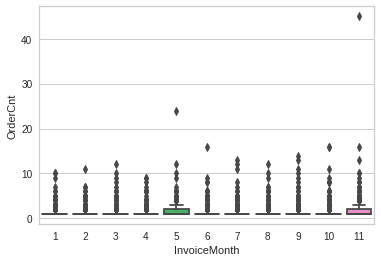

In [ ]:
# 5. 고객들의 월별 주문(횟)수 분포 : 한 달에 몇번씩 주문을 할까? 
monthlyOrderCnt = (df
                  .groupby(['CustomerID', 'InvoiceMonth'])[['InvoiceNo']]
                  .nunique()
                  .reset_index()
                  .rename(columns={'InvoiceNo':'OrderCnt'}))

order_cnt_df = monthlyOrderCnt.pivot_table(index='CustomerID', columns='InvoiceMonth', values='OrderCnt').fillna(0)

sns.boxplot(data=monthlyOrderCnt, x='InvoiceMonth', y='OrderCnt');

order_cnt_df

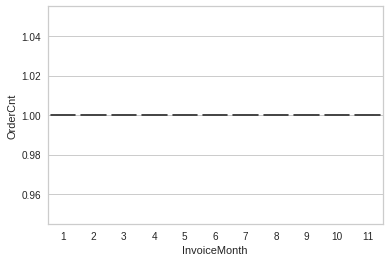

In [ ]:
# 월 주문수가 높은 순 ~ 낮은순으로 정렬했을때, 상위 10%를 제외하고 나머지만 확대해서 본다.
# 이 직선이 의미하는 바가 뭐냐면, 상위 10%를 제외하고는 모든 고객이 한 달에 한 번만 주문을 한다는 뜻이다.
cutoff= monthlyOrderCnt['OrderCnt'].quantile(0.9)
sns.boxplot(data=monthlyOrderCnt[monthlyOrderCnt['OrderCnt'] < cutoff], x='InvoiceMonth', y='OrderCnt');

InvoiceMonth,1,2,3,4,5,6,7,8,9,10,11
CustomerID,,,,,,,,,,,
12346,77183.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
12747,303.04,0.00,310.78,0.00,771.31,376.30,0.00,301.70,0.00,675.38,312.73
12748,418.77,389.64,1179.37,1100.37,2234.50,2006.26,1113.27,898.24,6148.84,2292.84,10639.23
12749,0.00,0.00,0.00,0.00,859.10,0.00,0.00,1896.13,0.00,0.00,572.59
12820,170.46,0.00,0.00,0.00,0.00,0.00,0.00,0.00,217.77,343.76,0.00
...,...,...,...,...,...,...,...,...,...,...,...
18280,0.00,0.00,180.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
18281,0.00,0.00,0.00,0.00,0.00,80.82,0.00,0.00,0.00,0.00,0.00
18282,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.21,0.00,0.00,0.00


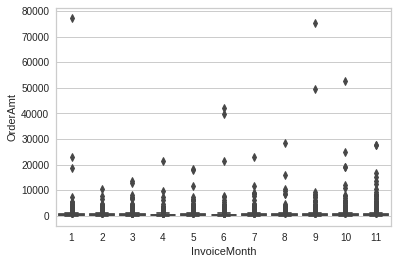

In [ ]:
# 6. 고객들의 월별 주문금액 분포 : 고객들은 한달에 얼만큼의 지출을 할까?
df['OrderAmt'] = df['Quantity'] * df['UnitPrice']

monthlyOrderAmt = (df
                  .groupby(['CustomerID', 'InvoiceMonth'])[['OrderAmt']]
                  .sum()
                  .reset_index()
)

order_amt_df = monthlyOrderAmt.pivot_table(index='CustomerID', columns='InvoiceMonth', values='OrderAmt').fillna(0)

sns.boxplot(data=monthlyOrderAmt, x='InvoiceMonth', y='OrderAmt');
order_amt_df

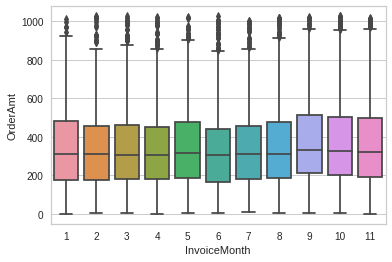

In [ ]:
# 월지출이 높은 순 ~ 낮은순으로 정렬했을때, 상위 10%를 제외하고 나머지만 확대해서 본다.
# 대부분 월 객단가가 200-500달러에 형성되어있음을 알 수 있음. 
cutoff= monthlyOrderAmt['OrderAmt'].quantile(0.9)
sns.boxplot(data=monthlyOrderAmt[monthlyOrderAmt['OrderAmt'] < cutoff], x='InvoiceMonth', y='OrderAmt');

In [ ]:
"""
7. 월별 ARPPU(Average Revenue Per Paying User, 결제자 인당 평균 결제액, 실제 구매고객의 성향 파악)

@ 계산법
  기준을 월(Month)로 잡았기때문에, 월별 총 결제액(Monthly Revenue)/ 해당 월에 결제한 고객수(Monthly Paying User)로 계산한다.

@ 언제 사용하는가?
  ARPPU는 구매고객을 대상으로 산정한 지표이기 때문에, 서비스 유료화나 프리미엄 혜택 등을 만들 때 참고하기도 하는데
  ARPU(Average Revenue Per User, 이용자 전체의 구매성향 파악)을 함께 비교하면서 
  우리 서비스가 충성도 높은 소수 고객이 매출의 대부분을 가져다주는지, 아니면 대다수의 유저들이 골고루 매출에 기여하는지를 가늠한다.
  해당 데이터로는 구매고객만 알 수 있어 ARPU를 비교하지 못해 아쉽지만,
  이 지표 하나만으로도 실제 구매고객의 성향을 알 수 있어 Revenue 를 파악하는데 도움이 된다.

@ ARPPU가 올랐다면 ?
  1) 구매고객수가 같다는 가정하에 매출이 올랐거나
  2) 매출이 같다는 가정하에 구매고객수가 줄었다는 뜻이므로
  ARPPU가 올랐다고 좋아하면 안되고, 구매고객수와 매출을 함께 봐야한다. 

@ 아래 표를 해석하자면?
  구매고객 1명당 월평균 520~690달러 사이의 매출이 발생한다.
  상반기보다 하반기로 갈수록 구매고객과 매출이 함께 늘면서 ARPPU가 상승하는 패턴이지만
  1월은 매출대비 고객수가 줄었기 때문에 ARPPU가 높게 찍혔다.
"""

ARPPU_df = (df
            .groupby('InvoiceMonth')
            .agg({'OrderAmt':'sum', 'CustomerID':'nunique'})
            .rename(columns={'OrderAmt':'MonthlyRevenue', 'CustomerID':'UniquePayingUser'})
)

ARPPU_df['ARPPU'] = ARPPU_df['MonthlyRevenue'] /  ARPPU_df['UniquePayingUser'] 

cm = sns.light_palette("blue", as_cmap=True)
ARPPU_df.style.background_gradient(cmap=cm)

,MonthlyRevenue,UniquePayingUser,ARPPU
InvoiceMonth,,,
1,442190.060000,647,683.446770
2,355655.630000,679,523.793270
3,467198.590000,880,530.907489
4,409559.141000,784,522.396864
5,551568.820000,962,573.356362
6,524915.480000,889,590.456108
7,485612.251000,859,565.322760
8,498453.320000,834,597.665851
9,796780.272000,1146,695.270743


In [ ]:
"""
8. 구매일자를 바탕으로 계산한 Retention(잔존율)

@ Retention이란?
우리 서비스에 한 번 들어온 고객이, n기간 후에도 재접속/재구매등을 꾸준히 하고있나?를 볼 때 사용하는 지표.
리텐션이 높은 서비스 ==> 고객들이 이미 A HA Moment를 경험한 좋은 서비스.
비즈니스 형태에 따라 주기를 다르게 계산한다.(ex. 모바일게임-> 1day retention, 여행업계-> 1month retention)
위에서 살펴봤듯이 전체 중 90%의 고객이 월 1회 구매를 하고있으니, 여기서는 month를 주기로 선택함.

@ 어떻게 계산하나요?
Classic, Range, Rolling retention등 여러가지가 있지만 
첫 구매날짜와 마지막 구매날짜만 있으면 계산이 가능한 Rolling retention을 계산한다.
"""

user_df = pd.DataFrame(df['CustomerID'].unique())
user_df.columns = ['CustomerID']

minOrderedM = df.groupby('CustomerID')[['InvoiceMonth']].min().rename(columns={'InvoiceMonth':'firstOrderdMonth'})
maxOrderedM = df.groupby('CustomerID')[['InvoiceMonth']].max().rename(columns={'InvoiceMonth':'lastOrderedMonth'})

user_df = user_df.merge(minOrderedM, on='CustomerID')
user_df = user_df.merge(maxOrderedM, on='CustomerID')


# 테이블을 가로로 더하면 해당 월에 첫 구매한 신규 유저수가 나옴
# 테이블을 세로로 더하면, 해당 월에 구매한 MAU(Active의 기준이 구매라 가정)가 나옴 
# 이 표를 해석하면, 1월에 가입해서 1월을 마지막 구매로 이탈한 고객이 80명, 
# 1월에 가입해서 2월구매를 마지막으로 이탈한 고객이 9명... 처럼 해석할 수 있다.
# 표에서는 신규고객수가 점차 감소하다가 9월부터 다시 상승세를 보이는데,
# 동시에 9월부터 첫달 이탈고객이 늘어난다.(80->89->141->....167->260) 
retention_df = user_df.pivot_table(index='firstOrderdMonth', columns='lastOrderedMonth', values='CustomerID' ,aggfunc=lambda x: len(x.unique()))
retention_df['NewbieCnt'] = retention_df.sum(axis=1)
retention_df


lastOrderedMonth,1,2,3,4,5,6,7,8,9,10,11,NewbieCnt
firstOrderdMonth,,,,,,,,,,,,
1,80.0,9.0,8.0,11.0,20.0,16.0,13.0,26.0,44.0,93.0,327.0,647.0
2,NaN,89.0,12.0,5.0,10.0,16.0,14.0,26.0,44.0,74.0,156.0,446.0
3,NaN,NaN,141.0,8.0,19.0,17.0,21.0,21.0,52.0,70.0,153.0,502.0
4,NaN,NaN,NaN,109.0,9.0,15.0,14.0,23.0,28.0,41.0,96.0,335.0
5,NaN,NaN,NaN,NaN,103.0,15.0,11.0,12.0,30.0,43.0,77.0,291.0
6,NaN,NaN,NaN,NaN,NaN,102.0,9.0,8.0,15.0,28.0,77.0,239.0
7,NaN,NaN,NaN,NaN,NaN,NaN,95.0,10.0,13.0,23.0,52.0,193.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.0,13.0,24.0,38.0,157.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,167.0,36.0,89.0,292.0


In [ ]:
# 우리는 몇명이 나갔냐보단, n월에 들어온 고객 대비 몇 퍼센트정도 남았냐를 알고싶은 것이므로 보기 편하게 계산해준다.

del retention_df['NewbieCnt']
# 만들어진 테이블을 가로로 더하면 ==> n월에 첫 구매한 신규 고객수
# 가입한 전체고객대비 이탈고객의 비율을 계산
retention_df = retention_df.div(retention_df.sum(axis=1), axis=0)

# 컬럼순서 반대로 누적해서 더하면, 남아있는 고객의 비율이 나온다.
retention_df = retention_df[retention_df.columns[::-1]].cumsum(axis=1)[retention_df.columns]
retention_df

lastOrderedMonth,1,2,3,4,5,6,7,8,9,10,11
firstOrderdMonth,,,,,,,,,,,
1,1.0,0.876352,0.862442,0.850077,0.833076,0.802164,0.777434,0.757342,0.717156,0.649150,0.505410
2,NaN,1.000000,0.800448,0.773543,0.762332,0.739910,0.704036,0.672646,0.614350,0.515695,0.349776
3,NaN,NaN,1.000000,0.719124,0.703187,0.665339,0.631474,0.589641,0.547809,0.444223,0.304781
4,NaN,NaN,NaN,1.000000,0.674627,0.647761,0.602985,0.561194,0.492537,0.408955,0.286567
5,NaN,NaN,NaN,NaN,1.000000,0.646048,0.594502,0.556701,0.515464,0.412371,0.264605
6,NaN,NaN,NaN,NaN,NaN,1.000000,0.573222,0.535565,0.502092,0.439331,0.322176
7,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.507772,0.455959,0.388601,0.269430
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.477707,0.394904,0.242038
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.428082,0.304795


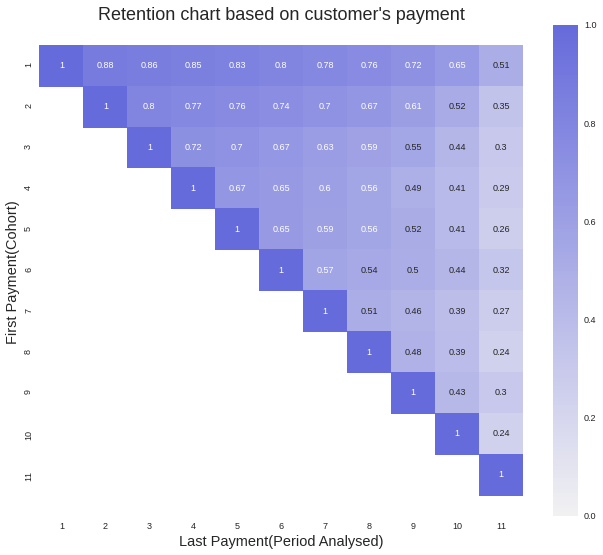

In [ ]:
"""
보기 쉽게 아래처럼 그렸다.
가로축의 데이터가 의미하는건, n월에 가입한 고객이 1,2,...m개월이 지날 때까지 얼만큼 남아있는지를 보여주고,
왼쪽상단에서 오른쪽하단으로 가는 대각선이 의미하는건 같은 m개월이 지났을 때, 가입월별로 나눈 고객집단별 잔존율 차이다. 
이 그래프를 보면 1월에 가입한 고객중, 절반이 11월까지 활동을 유지하고 있는데,
최근에 가입한 고객일수록 절반으로 떨어지는 시기가 점점 빨라진다. 
가입하고 한 달후 잔존율이 88%에서 24%로 쭉 하락하는 패턴이 재밌는데
직관적으로 해석하자면 가입후 한달뒤에 우리고객으로 남아있을 확률이 연 초에는 88%정도 됬다면 후반부에는 24%까지 떨어진다는 뜻이다.
한달 후 리텐션이 이정도를 유지한다면 사실 이미 성공한 서비스인데, 잘나가던 초반에 비해 후반이 쭉 떨어진다는건
하반기에 가입 마케팅을 세게 때리는 탓에 체리피커가 많았거나, 유저들이 흥미를 잃고 떠나는중이라고 해석할 수 있다. 
"""

# Plot
plt.figure(figsize=(12,10), dpi= 65)
cmap = sns.diverging_palette(245, 265, as_cmap=True)

ax = sns.heatmap(retention_df
            , xticklabels=retention_df.columns
            , yticklabels=retention_df.columns
            , cmap=cmap
            , center=0
            , annot=True
            , vmin=0, vmax=1)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# Decorations
plt.title('Retention chart based on customer\'s payment', fontsize=20)
plt.xlabel('Last Payment(Period Analysed)', fontsize=16)
plt.ylabel('First Payment(Cohort) ', fontsize=16)
plt.show()

---
#### **PART3 : Train/Test set 분리, Feature Engineering, 기준모델(baseline)만들기**

#####  **어떻게 분리하는가?**

1. 우리는 '구매데이터를 활용해서, 앞으로 n기간에 고객이 매출을 얼만큼 가져다 줄지'를 알고 싶다. 

2. 고객들의 월별 주문수, 주문금액등을 참고했을 때 시즌성이 있거나 한 쪽에 편향되어있는 데이터는 아니지만, n월에 가입한 고객이 다음달에도 남아있을 확률이 최소 50% 내외는 되는, 1~9월까지의 데이터셋을 사용한다. (PART2 : Data Wrangling 파트 참조)

3. 1월 ~ 6월사이 6개월치 데이터를 가지고, 3개월후(7월 ~ 9월) 고객의 LTR class를 예측하는 모델을 만들겠다. 따라서 1 ~ 6월 사이 데이터는 Training set, 7 ~ 9월 데이터는 Test set이 된다. 이 때 Test set을 바로 검증하지 않고, 훈련이 잘 되었는지 확인하기 위해 Training set에서 무작위로 25%를 뽑아내 검증(Validation set)에 사용한다.

4. 엄밀히 말하면 시계열 예측이라 고려해야할게 많지만, 이번에서는 논외로 한다.

5. LTR 예측은 회귀문제지만, 여기서는 고객별로 예측한 LTR을 높은LTR/낮은LTR 두 개의 class로 나누어, 고객의 LTR이 높은지, 낮은지를 예측하는 분류문제로 풀겠다.


##### **feature engineering은 어떻게 할건가?**
1. RFM 프레임워크를 적용해서 고객 Segment를 나눠본다.

2. 고객이 한 주문당 평균 몇 종류의 상품(SKU의 개념), 몇 개의 상품(total ordered count)을 구매했는지 만들어본다. 

In [ ]:
# train, val, test의 베이스가 될 df_6m, target으로 사용할 df_3m을 분리해줌.
df_6m = df[df['InvoiceMonth']<7]
df_3m = df[(df['InvoiceMonth']>=7) & (df['InvoiceMonth']<10)]

In [ ]:
def RFM_process(df):
  """
  Unique CustomerID를 기준으로, R(Recency), F(Frequency), M(Monetary)을 계산해 user_rfm_df를 만들어줌.
  
  Input:
  @df(DataFrame) : 전처리 후 가져온 구매데이터. CustomerID, InvoiceDate, InvoiceNo, Quantitly, UnitPrice 컬럼을 갖고있어야 함. 
  
  Return:
  @user_rmf_df(DataFrame) : 고객별로 얼마나 최근에, 얼마나 자주, 얼마나 많이 구매했는지 수치화한 데이터를 의미함.
  """

  # RFM은 고객별로 R의 구간, F의 구간, M의 구간이 정해지기때문에 고유한 CustomerID를 기준으로 R,F,M 정보를 붙여나가야 함.
  # 데이터는 주문한 상품을 기준으로 펼쳐져있기때문에, 고객ID가 중복되어 들어가있으니, unique 한 것만 뽑아놓는다.
  user_df = pd.DataFrame(df['CustomerID'].unique())
  user_df.columns = ['CustomerID']

  # Recency. 얼마나 최근에 결제 했는가? ex) 최근3개월, 최근6개월, 최근1년
  print('주문일자의 범위 :', df['InvoiceDate'].min(), '~ ', df['InvoiceDate'].max())

  # 모델이 인식하기 쉽도록, datetime을 numeric하게 바꿔보겠음.
  # 최근일수록 높은 점수를 부여해주기 위해,주문이 가장 최초에 발생한 날로부터 얼마나 떨어진 날에 마지막 주문을 했는지 걸린 일수를 고객별로 만들어주겠음.
  # 최근일수가 0이 되지 않도록, 최소 1을 맞춰주기 위해 min date보다 하루 전을 oldest_day로 설정함.
  oldest_day = df['InvoiceDate'].min() -  pd.to_timedelta(1, unit='d')

  # 고객별로 가장 마지막에 주문한 날짜 -  (2011년에 주문이 발생한 최초의 날-1일)을 계산해, recency를 만들어줌.
  max_purchase_df = df.groupby('CustomerID').InvoiceDate.max().reset_index().rename(columns={'InvoiceDate':'MaxPurchaseDate'})
  max_purchase_df['Recency'] = (max_purchase_df['MaxPurchaseDate'] - oldest_day).dt.days 

  # 아까 만들어뒀던 Unique Customer ID를 기준으로, Recency column을 더해 user_rmf_df를 만들어준다.
  user_rfm_df = user_df.merge(max_purchase_df[['CustomerID', 'Recency']], on='CustomerID')


  # Frequency : 얼마나 자주 결제했는가? ex) 1~3회, 4~10회, 11회 이상 
  # 고객별로, 주문한 횟수를 만들어준다. 이 때 InvoiceNo의 고유한 값을 count한다.
  order_cnt_df = df.groupby('CustomerID')[['InvoiceNo']].nunique().reset_index().rename(columns={'InvoiceNo':'Frequency'})
  user_rfm_df = user_rfm_df.merge(order_cnt_df, on='CustomerID')


  # Monetary : 얼마나 많이 결제했는가? ex) n원 이하, n원~m원, m원 이상
  # Monetary = Quantity * UnitPrice 
  df['Monetary'] = df['Quantity'] * df['UnitPrice']
  revenue_df = df.groupby('CustomerID')[['Monetary']].sum().reset_index()
  user_rfm_df = user_rfm_df.merge(revenue_df, on='CustomerID')
  
  print('\n ============= return sample ============= ')
  print(user_rfm_df.head())
  return user_rfm_df

user_rfm_df = RFM_process(df_6m)

주문일자의 범위 : 2011-01-04 10:00:00 ~  2011-06-30 20:08:00

 ============= return sample ============= 
  CustomerID  Recency  Frequency  Monetary
0      13313      125          2    609.74
1      18097      135          2   1274.04
2      16656      147          5   3128.72
3      16875       44          3    805.09
4      13094      149          7    869.40


In [ ]:
# user_rfm_df 데이터 분포를 보고, 단위가 제각기 다른 데이터를 custom normalization을 한다.
# 전체적으로 우리 유저는 비교적 최근에 구매한 사람이 많고, 대부분 주문빈도가 적고, 결제액의 편차가 큰 편이다.
user_rfm_df.describe()[3:].style.bar(subset=['Recency', 'Frequency', 'Monetary'], align='mid', color=['#6b75fa'])

,Recency,Frequency,Monetary
min,1.000000,1.000000,2.900000
25%,85.000000,1.000000,237.435000
50%,132.000000,2.000000,463.395000
75%,158.000000,3.000000,1002.787500
max,178.000000,67.000000,78766.940000


In [ ]:
# 위에서 도출한 R,F,M을 그대로 사용하면, 각 feature별 단위도 제각기 다르고 편차도 다르기에, 학습에 적합하지 않을 수 있다.
# 만약 비즈니스 상황에 맞게 등급제나, 고객집단을 나누는 특성이 있다면 직접 cutoff를 정해주어 나눠도된다.

def custom_normalization(user_rfm_df, ranking, freq_cut_lst, mon_cut_list):
  """
  고객별 R,F,M끼리 서로 단위가 달라, 기계가 잘 해석할 수 있도록 단위를 맞춰주는 정규화 과정.
  각 feature별로 기준을 세우고, 그룹을 나눈뒤 1~5사이의 정규화된 값으로 라벨링한 R_score, F_score, M_score를 만듬.
  
  Input:
  @user_rfm_df(DataFrame) : user별 R,F,M feature가 존재하는 데이터프레임.
  @ranking(Series) : Recency를 나눌 기준. Recency 크기별로 1~n등까지 순위가 매겨져있어야 한다.
  @freq_cut_lst(list) : Frequency를 나눌 기준. 4개의 label을 생성하므로 len(freq_cut_lst)은 5여야 한다.
  @mon_cut_lst(list) : Monetary를 나눌 기준. 5개의 label을 생성하므로 len(freq_cut_lst)은 6여야 한다.

  Return:
  @user_rfm_df(DataFrame) : Input으로 넣은 user_rfm_df에 R_score, F_score, M_score가 추가된 데이터프레임.
  """

  user_rfm_df['R_score'] = pd.qcut(ranking, 5, labels=[1,2,3,4,5])
  print('\n ========== R_score 통계량 ========== ')
  print(user_rfm_df.groupby('R_score')['Recency'].agg(['count', 'mean', 'max', 'std']))


  user_rfm_df['F_score'] = pd.cut(user_rfm_df['Frequency'], freq_cut_lst, labels=[1,2,3,4])
  print('\n ========== F_score 통계량 ========== ')
  print(user_rfm_df.groupby('F_score')['Frequency'].agg(['count', 'mean', 'max', 'std']))

  user_rfm_df['M_score'] = pd.cut(user_rfm_df['Monetary'], mon_cut_lst, labels=[1,2,3,4,5])
  user_rfm_df['M_score'].fillna(1, inplace=True)
  print('\n ========== M_score 통계량 ========== ')
  print(user_rfm_df.groupby('M_score')['Monetary'].agg(['count', 'mean', 'max', 'std']))

  print('\n ========================== return sample ========================== ')
  print(user_rfm_df.head())

  return user_rfm_df

# Recency의 분포가 다른 feature들의 분포보다 비교적 덜 치우쳐져있어서
# 각 value의 크기를 1등부터 n등까지 나열하여, 이를 5등분을 하되 각 score별로 동일한 데이터 수를 가질 수 있도록 pandas의 qcut을 사용해 등분한다.
ranking = user_rfm_df['Recency'].rank(method='first')

# Frequency는 EDA과정에서도 살펴봤지만, 90%이상이 월 1회만 주문하는 매우 편향된 데이터이다.
# 따라서 분위수나 qcut으로 나눠주지 않고 임의의 값을 주어 등분해줌.
# 최대한 유저를 골고루 나누기 위해, 간격설정을 좁게 했음에도 값이 작은 label에 분포가 몰려있는 것을 알 수 있음.
freq_cut_lst = [0, 1, 2, 4, 100]

# Monetary 역시 편향되어있게 보이긴 하지만, 금액의 단위이다보니 더 크게 느껴지는 듯 해서,
# 유사한 간격의 분위수를 활용해서 등분해줌.
mon_cut_lst = user_rfm_df['Monetary'].quantile([0, 0.3, 0.5, 0.7, 0.9, 1]).tolist()

user_rfm_df = custom_normalization(user_rfm_df, ranking=ranking, freq_cut_lst=freq_cut_lst, mon_cut_list=mon_cut_lst)


 ========== R_score 통계량 ========== 
         count        mean  max        std
R_score                                   
1          492   41.276423   74  20.717792
2          492   94.563008  118  11.890287
3          492  131.252033  142   6.450619
4          492  153.977642  163   5.797456
5          492  170.813008  178   4.596288

 ========== F_score 통계량 ========== 
         count      mean  max       std
F_score                                
1         1172  1.000000    1  0.000000
2          535  2.000000    2  0.000000
3          432  3.354167    4  0.478815
4          321  9.242991   67  7.320572

 ========== M_score 통계량 ========== 
         count         mean       max          std
M_score                                           
1          738   162.620596    278.63    64.753635
2          492   352.553232    463.38    50.625421
3          492   640.151057    853.98   112.113080
4          492  1289.683130   1996.96   324.710130
5          246  6130.646793  78766.94  977

최적의 k : 3
최적의 k의 y값 : 4091.199


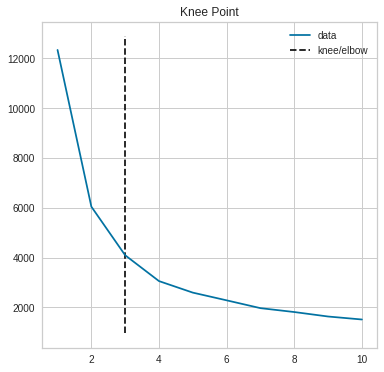

In [ ]:
# 정규화된 score를 바탕으로, 고객 집단을 군집화시켜보기
# step1 : 몇 개(k)의 집단으로 나누어야 고객이 몰리지 않고 유사한 분포를 가질까? 알아보기
# step2 : 찾은 최적의 k로 집단별 특성을 구분해보기

segment_df = user_rfm_df[['CustomerID', 'R_score', 'F_score', 'M_score']].set_index('CustomerID')

distortions = []
k_range = range(1, 11)

for i in k_range:
  km = KMeans(n_clusters=i, random_state=31)
  km.fit(segment_df)
  distortions.append(km.inertia_)

kneedle = KneeLocator(x=k_range, y=distortions, curve='convex', direction='decreasing')
print(f'최적의 k : {round(kneedle.elbow, 3)}')
print(f'최적의 k의 y값 : {round(kneedle.elbow_y, 3)}')
kneedle.plot_knee()

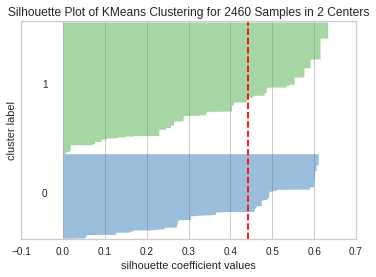

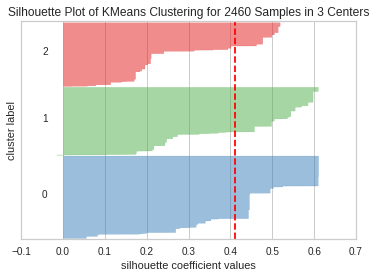

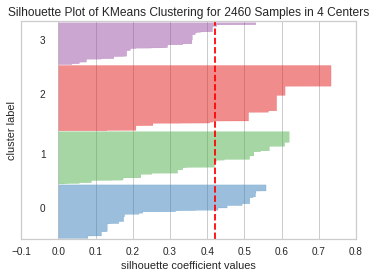

In [ ]:
# coefficient value가 낮아지긴 하지만, 군집이 균등하게 잘 나뉘기 시작하는 k도 3부터인것을 확인할 수 있음.
k_range = range(2, 5)
for i in k_range:
  km = KMeans(n_clusters=i, init='k-means++')
  visualizer = SilhouetteVisualizer(km)
  visualizer.fit(segment_df)
  visualizer.poof()

In [ ]:
# 3개의 집단으로 고객을 나누고, 어떤 특성을 가진 고객들로 나누어졌는지 해석하기 위해 고객 데이터에 라벨을 붙여준다.
model = KMeans(n_clusters=3, random_state=31)
km = model.fit(segment_df)
km_label = km.labels_

segment_df[['R_score', 'F_score', 'M_score']] = segment_df[['R_score', 'F_score', 'M_score']].astype(int)
segment_df['km_label'] = km_label
print(segment_df.head())

# 만든 라벨을 user_rfm_df에 붙여준다.
final_user_rfm_df = user_rfm_df.merge(segment_df[['km_label']], on='CustomerID')

            R_score  F_score  M_score  km_label
CustomerID                                     
13313             3        2        3         1
18097             3        2        4         0
16656             4        4        5         0
16875             1        3        3         2
13094             4        4        4         0


In [ ]:
# 고객집단 0은 마지막 구매일자가 최근이고, 구매 빈도, 구매금액도 높은 집단이다.
# 고객집단 1은 비교적 최근에 구매하긴 했으나, 구매빈도도 적고 구매금액도 적은 newbie일 가능성이 높다.
# 그에비해 고객집단 2는 오래전 구매가 마지막이었고, 구매빈도나 구매금액도 적은 고객집단이다.
# 1의 고객이 2로 가지 않고 0으로 갈 수 있도록 지속적인 관심이 필요해보인다.

cm = sns.light_palette("blue", as_cmap=True)
segment_df.groupby('km_label')['R_score', 'F_score', 'M_score'].mean().style.background_gradient(cmap=cm)

,R_score,F_score,M_score
km_label,,,
0,4.055128,3.267949,4.137179
1,3.840164,1.475410,1.918033
2,1.483122,1.258439,1.861814


In [ ]:
# 고객은 주문 한 건당 몇 가지의 상품 종류(meanItemUnit) 와, 몇 개의 상품(meanItemCnt)을 사는가? 같은 특성을 더 만들겠음.
# i.e. 고객A는 주문을 총 1번했고, 이 때 사과 5개와 배 3개를 샀다. 이 때 meanItemUnit=2, meanItemCnt=8
merge_data = (df_6m
              .groupby(['CustomerID', 'InvoiceNo'])
              .agg({'StockCode':'nunique', 'Quantity':'sum'})
              .reset_index()
              .groupby('CustomerID')[['StockCode','Quantity']]
              .mean()
              .reset_index()
              .rename(columns={'StockCode':'meanItemUnit', 'Quantity':'meanItemCnt'})
)

final_user_df = final_user_rfm_df.merge(merge_data, on='CustomerID')
final_user_df.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,km_label,meanItemUnit,meanItemCnt
0,13313,125,2,609.74,3,2,3,1,15.500000,165.500000
1,18097,135,2,1274.04,3,2,4,0,24.500000,415.000000
2,16656,147,5,3128.72,4,4,5,0,5.400000,625.600000
3,16875,44,3,805.09,1,3,3,2,15.333333,130.333333
4,13094,149,7,869.40,4,4,4,0,1.714286,108.000000


In [ ]:
# target의 베이스가 될, 7~9월까지 3분기 고객의 LTR를 만들어서 넣어줌.
LTR_3m_df = df_3m.groupby('CustomerID')[['OrderAmt']].sum().rename(columns={'OrderAmt':'LTR_3m'})
final_df = final_user_df.merge(LTR_3m_df, on='CustomerID')
final_df.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,km_label,meanItemUnit,meanItemCnt,LTR_3m
0,13313,125,2,609.74,3,2,3,1,15.500000,165.500000,308.60
1,18097,135,2,1274.04,3,2,4,0,24.500000,415.000000,554.84
2,16656,147,5,3128.72,4,4,5,0,5.400000,625.600000,3912.78
3,16875,44,3,805.09,1,3,3,2,15.333333,130.333333,333.11
4,13094,149,7,869.40,4,4,4,0,1.714286,108.000000,681.60


In [ ]:
# outlier 제거
cutoff = final_df['LTR_3m'].quantile(0.99)
final_df = final_df[final_df['LTR_3m']<cutoff]

# 2개의 집단으로 고객을 나누고, 어떤 특성을 가진 고객들로 나누어졌는지 해석하기 위해 고객 데이터에 라벨을 붙여준다.
# 사실상 silhouetteVisualizer로 확인결과, n이 11개는 되어야, 고객수 분포가 균등한 집단이 되지만 
# 현실적으로 고객집단을 동일한 수로 기대하여 멤버십등급을 만들지 않으며, 헤비유저가 매출의 큰 파이를 차지한다.
# 따라서 고객 분포는 논외로 하고, LTR이 높다/낮다 두 가지로만 구분지어 분류하고자 n_clusters=2 로 설정함.
LTR_df = final_df[['CustomerID', 'LTR_3m']].set_index('CustomerID')

model = KMeans(n_clusters=2, random_state=31)
km = model.fit(LTR_df)
km_label = km.labels_

LTR_df['LTR_cluster'] = km_label
print(LTR_df.head())

# Target인 LTR_cluster를 final_df에 붙여준다.
final_df = final_df.merge(LTR_df[['LTR_cluster']], on='CustomerID')
# 드디어 완성된 데이터셋
final_df.head()

             LTR_3m  LTR_cluster
CustomerID                      
13313        308.60            0
18097        554.84            0
16656       3912.78            1
16875        333.11            0
13094        681.60            0


,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,km_label,meanItemUnit,meanItemCnt,LTR_3m,LTR_cluster
0,13313,125,2,609.74,3,2,3,1,15.500000,165.500000,308.60,0
1,18097,135,2,1274.04,3,2,4,0,24.500000,415.000000,554.84,0
2,16656,147,5,3128.72,4,4,5,0,5.400000,625.600000,3912.78,1
3,16875,44,3,805.09,1,3,3,2,15.333333,130.333333,333.11,0
4,13094,149,7,869.40,4,4,4,0,1.714286,108.000000,681.60,0


In [ ]:
# 고객집단을 두 개로 나누어 각 feature들의 평균을 비교했다.
# 비교적 최근에 구매하고, 구매빈도, 구매금액, 주문당 평균 주문상품수량이 많은 1집단은 LTR이 높은 고객집단이고,
# 그와 반대되는 0집단은 LTR이 낮은 고객집단이다.
# 특이하게도 주문당 평균 구매하는 상품카테고리수는 약 21개로 유사했다.
final_df.groupby('LTR_cluster')[['Recency', 'Frequency', 'Monetary', 'meanItemUnit', 'meanItemCnt']].mean().style.background_gradient(cmap=cm)


,Recency,Frequency,Monetary,meanItemUnit,meanItemCnt
LTR_cluster,,,,,
0,129.339496,3.073950,979.889311,21.261231,208.101084
1,151.946809,9.531915,5349.937979,21.653623,497.488328


0    0.926791
1    0.073209
Name: LTR_cluster, dtype: float64


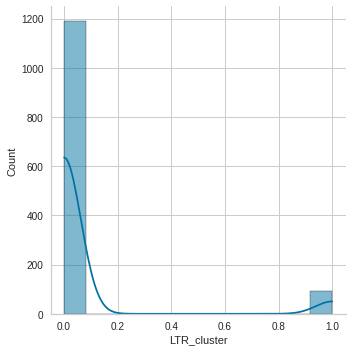

In [ ]:
# 집단별 분포를 비교했더니, 낮은 LTR을 가진 고객이 93%나 된다.
# '고객들은 모두 LTR이 낮을거야'로 예측하면, 예측정확도(accuracy)는 93%가 되버린다.
print(final_df['LTR_cluster'].value_counts(normalize=True))
sns.displot(final_df['LTR_cluster'],kde=True);

In [ ]:
# Baseline 
# 앞으로 모델의 검증정확도에 사용할 모든 지표는 0~1 사이의 값을 가지는데, 1에 가까울수록 정확도가 높다는 뜻이다. 
# 검증정확도가 약 0.93으로 나왔다. 과연 잘 만든 모델이라고 할 수 있을까? (=예측을 잘 하는 모델일까?)
target = final_df['LTR_cluster']

mode = final_df['LTR_cluster'].mode()[0]
baseline = [mode] * len(final_df)

print('accuracy_score of baseline : ', accuracy_score(target, baseline))

accuracy_score of baseline :  0.926791277258567


In [ ]:
# accuracy_score만 쓰면 안되는 이유를 좀 더 자세히 알기 위해,
# 아무것도 세팅하지않은 RandomForest 분류모델로 학습시켜서, 검증세트를 예측해본다.
final_df[['R_score', 'F_score', 'M_score']] = final_df[['R_score', 'F_score', 'M_score']].astype(int)
Train = final_df[final_df.columns.difference(['CustomerID', 'LTR_3m', 'LTR_cluster'])]
target = final_df['LTR_cluster']

Train, X_test, target, y_test = train_test_split(Train, target, stratify=target, random_state=31, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(Train, target, stratify=target, random_state=31, test_size=0.2)
print('X_train shape :', X_train.shape)
print('X_val shape :', X_val.shape)
print('X_test shape :', X_test.shape)


clf = RandomForestClassifier(random_state=31)
clf.fit(X_train, y_train)
y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)

print('=='*50)
print('accuracy score of RandomForestClassifier: ', clf.score(X_val, y_val))
print('f1 score of RandomForestClassifier: ', f1_score(y_val, y_val_pred))

print('\n', classification_report(y_val, y_val_pred))

X_train shape : (821, 9)
X_val shape : (206, 9)
X_test shape : (257, 9)
accuracy score of RandomForestClassifier:  0.9563106796116505
f1 score of RandomForestClassifier:  0.608695652173913

               precision    recall  f1-score   support

           0       0.96      0.99      0.98       191
           1       0.88      0.47      0.61        15

    accuracy                           0.96       206
   macro avg       0.92      0.73      0.79       206
weighted avg       0.95      0.96      0.95       206



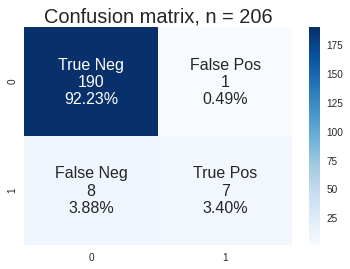

In [ ]:
"""
@ accuracy? recall? precision? f1_score ? 
  accuracy는 전체고객중에 고객들이 가진 LTR 집단을 제대로 맞춘 비율을말하는거고,
  precision은 LTR이 높다고 예측한것들 고객중에(TP+FP) 진짜 LTR이 높은 고객(TP)의 비율
  recall은 실제로 높은 LTR을 가진 고객중에(TP+FN) 진짜 LTR이 높은 고객(TP)의 비율을 의미한다.
  f1_score는 precision과 recall의 조합으로 만들어진 검증지표이다.

@ 그럼 이중에 어떤 지표를 활용해야 하는가?
  애초에 LTR이 낮은 고객이 93%나 되니, 다 LTR이 낮다고 찍어도 93%의 정확도를 가질 수 있게 되기때문에
  분류문제에서 타겟 클래스비율이 70% 이상 차이날 경우에는 정확도만 사용하면 판단을 정확히 할 수 없으며
  precision, recall를 함께 봐야하고, accuracy_score만 보기보단 f1_score를 지표로 쓰는 것이 더 바람직하다. 
"""

fig, ax = plt.subplots()
# Set general font size
plt.rcParams['font.size'] = '16'

cf_matrix = confusion_matrix(y_val, y_val_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.array(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=20)
plt.show()

AUC score:  0.9296684118673648


Text(0, 0.5, 'TPR')

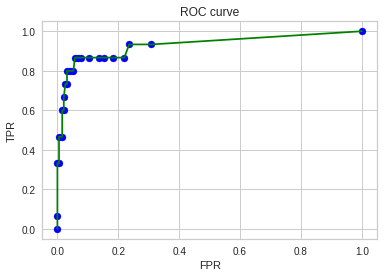

In [ ]:
# ROC curve
y_pred_proba = clf.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

---

#### **PART4. 예측모델 만들고, 검증하기**

1. RandomForest와 XGBoost으로 모델 만들고, f1 score와 Classification Report로 성능 검증하기
2. 하이퍼파라미터 튜닝해보기 

##### **다시 한 번, 우리의 목적은 무엇인가?**
우리의 목적은 전체의 약7% 밖에 안되는 LTR cluster==1 집단을 잘 예측해내는 것이다. 

매출에 큰 기여를 하는 고객은 LTR cluster가 1인, 즉 LTR이 높은 충성고객 집단이기 때문이다.

##### **어떤 모델이 더 좋은 모델인가?**
기계학습에서 예측/분류를 잘못하는 오류는 늘 어느정도 있을 수 밖에 없다.
 
이 때 어떤 모델이 더 좋은 모델인지 결정하려면 The lesser of two evils 문제에 부딪힌다.

*   충성고객이라고 판단했다가, 알고보니 일반유저인게 더 나쁠까
(==> 1종오류. 이 오류가 많아질수록 Precision이 작아짐)
*   일반유저라고 판단했다가, 알고보니 충성고객인게 더 나쁠까?
(==> 2종오류. 이 오류가 많아질수록 Recall이 작아짐) 


충성고객에게 혜택을 더준다고 했을때(=돈을 들인다고 했을때) 충성고객이라고 판단했으나 알고보니 일반유저인 비율이 많다면
회사에서도 비용이 더 늘어나게 되니, 여기서는 비교적 Precision을 더 올리는 모델이 추후 전략을 세울 때도 더 도움이 될 것 같다.



##### **왜 RandomForestClassifier와 XGBClassifer를 사용했는가?**

<img src='https://trees.gamemeca.com/wp-content/uploads/2020/06/200623_guardiantales_yesno_01_3.jpg' width='400'>

1. 트리 앙상블은 랜덤포레스트나 그래디언트 부스팅 모델같은 여러 문제에서 좋은 성능을 보인다.

2. 트리모델은 non-linear, non-monotonic 관계, 특성간 상호작용이 존재하는 데이터 학습에 적용하기 좋다.

3. 한 트리를 깊게 학습시키면 과적합을 일으키기 쉽기 때문에, 배깅(Bagging, 랜덤포레스트)이나 부스팅(Boosting) 앙상블 모델을 사용해 과적합을 피한다.

4. 
랜덤포레스트의 장점은 하이퍼파라미터에 상대적으로 덜 민감한 것인데, 
그래디언트 부스팅의 경우 하이퍼파라미터 셋팅에 따라 랜덤포레스트 보다 더 좋은 예측 성능을 보여줄 수도 있다.

In [ ]:
"""
@ RandomForest 모델에서 튜닝할 때 쓰이는 하이퍼파라미터들

  class_weight (imbalanced 클래스인 경우)
  max_depth (높은값에서 감소시키며 튜닝, 너무 깊어지면 과적합)
  n_estimators (적을경우 과소적합, 높을경우 긴 학습시간)
  min_samples_leaf (과적합일경우 높임)
  max_features (줄일 수록 다양한 트리생성, 높이면 같은 특성을 사용하는 트리가 많아져 다양성이 감소)
"""

rand_clf = RandomForestClassifier(
          n_estimators=100,
          random_state=2,
          n_jobs=-1,
          class_weight = 'balanced')

"""
@ XGBoost 모델 튜닝할 때 자주 쓰이는 하이퍼파라미터들

  scale_pos_weight (imbalanced 클래스인 경우)
  max_depth (낮은값에서 증가시키며 튜닝, 너무 깊어지면 과적합)
  n_estimators (작을경우 과소적합, 높을경우 긴 학습시간) - Early Stopping 사용!
  learning_rate (작을경우 과소적합, 높을경우 과적합)
"""

vc = y_train.value_counts().tolist()
# sum(negative instances) / sum(positive instances)
ratio = float(vc[0]/vc[1])

xgb_clf = XGBClassifier(
    n_estimators=100,  
    max_depth=7,        # default=3, high cardinality 특성을 위해 기본보다 높여줌.
    learning_rate=0.2,
    scale_pos_weight=ratio, # imbalance 데이터 일 경우 사용함. 위에서 계산한 target의 비율을 적용해준다.
    n_jobs=-1
)

In [ ]:
def train_predict_getReport(model):
  """
  만든 model을 넣으면 Training set을 학습하고, Validation set으로 예측을 한다.
  동시에 모델의 디테일, f1 score, Classification report를 보여준다.
  """
  model.fit(X_train, y_train)
  y_val_pred = model.predict(X_val)
  print(f'model description : {model}\n')
  print(f'accuracy of validation set: {round(accuracy_score(y_val, y_val_pred),4)}')
  print(f'f1_score of validation set: {round(f1_score(y_val, y_val_pred),4)}\n')
  print('=============== Classification Report ===============')
  print(classification_report(y_val, y_val_pred))

train_predict_getReport(rand_clf)

model description : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

accuracy of validation set: 0.9515
f1_score of validation set: 0.6154

=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       191
           1       0.73      0.53      0.62        15

    accuracy                           0.95       206
   macro avg       0.85      0.76      0.79       206
weighted avg       0.95      0.95 

In [ ]:
train_predict_getReport(xgb_clf)

model description : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=12.683333333333334,
              seed=None, silent=None, subsample=1, verbosity=1)

accuracy of validation set: 0.9417
f1_score of validation set: 0.625

=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       191
           1       0.59      0.67      0.62        15

    accuracy                           0.94       206
   macro avg       0.78      0.82      0.80       206
weighted avg       0.95      0.94      0.94       206



In [ ]:
# 하이퍼파라미터 튜닝 : RandomForestClassfier

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 1000, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4, 8, 12, 16]

dists = {
    'max_depth' : max_depth,
    'n_estimators' : n_estimators, 
    'max_features' : max_features,
    'min_samples_leaf' : min_samples_leaf
}

print('Customized parameters :')
print(dists)

RSCV_rand_clf = RandomizedSearchCV(
    rand_clf, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='f1',  # for binary targets
    verbose=1,
    n_jobs=-1
)

print('Applying RandomizedSearchCV & Fitting Training Data .....')
print('Note : It takes pretty long time, so you can refresh your head but DO NOT REFRESH the code blocks !!')
%timeit
RSCV_rand_clf.fit(X_train, y_train);


Customized parameters :
{'max_depth': [2, 12, 23, 34, 45, 56, 67, 78, 89, 100, None], 'n_estimators': [20, 71, 123, 174, 226, 277, 329, 381, 432, 484, 535, 587, 638, 690, 742, 793, 845, 896, 948, 1000], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 4, 8, 12, 16]}
Applying RandomizedSearchCV & Fitting Training Data .....
Note : It takes pretty long time, so you can refresh your head but DO NOT REFRESH the code blocks !!
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   50.4s finished


In [ ]:
print('randomForestClassifier의 최적 하이퍼파라미터: ', RSCV_rand_clf.best_params_)
print('f1 score: ', RSCV_rand_clf.best_score_)

# rank_test_score: 테스트 순위
pd.DataFrame(RSCV_rand_clf.cv_results_).sort_values(by='rank_test_score').T

randomForestClassifier의 최적 하이퍼파라미터:  {'n_estimators': 71, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 78}
f1 score:  0.6135143288084465


,32,21,39,22,41,30,42,17,1,5,36,10,14,43,26,38,48,6,0,35,29,12,13,19,7,4,33,23,8,25,24,16,15,2,37,11,28,27,18,40,3,20,9,44,49,46,34,45,31,47
mean_fit_time,0.252488,0.252113,1.50284,0.115529,1.63608,2.18369,0.49629,1.33345,1.31018,1.36064,0.695791,0.983802,1.20009,1.05027,0.955612,0.648904,0.605845,2.45637,0.256605,0.125908,0.120217,0.387825,0.661298,0.248349,2.49496,0.723415,0.968897,0.800155,1.71553,1.22901,2.19141,2.09571,1.05701,1.9878,1.233,2.14308,1.25838,1.87659,1.96283,2.49203,2.44625,0.878768,0.252574,0.248418,0.116762,1.61857,1.73454,0.654216,1.16173,1.00827
std_fit_time,0.00352346,0.00447328,0.00188914,0.00445944,0.0217794,0.0183056,0.0407168,0.0466492,0.0784311,0.00364403,0.0168141,0.056263,0.0139126,0.00219473,0.00690849,0.014954,0.0676176,0.0112207,0.00279422,0.0102669,0.00686977,0.00456783,0.0107791,0.00130147,0.0768113,0.0431315,0.0369836,0.095382,0.0466901,0.0273296,0.0687646,0.0684829,0.0131035,0.0682338,0.0212053,0.0380622,0.0313036,0.0450475,0.0518213,0.0151108,0.0638363,0.0540107,0.00152843,0.00322875,0.00332298,0.00942751,0.00807619,0.0285408,0.0323857,0.0396511
mean_score_time,0.106461,0.104558,0.212661,0.10443,0.210315,0.243335,0.105095,0.209613,0.177139,0.220079,0.107136,0.110001,0.139075,0.171808,0.118486,0.108341,0.104373,0.273418,0.10428,0.108374,0.11342,0.105665,0.11506,0.112299,0.243483,0.105094,0.11394,0.113028,0.206078,0.113293,0.20606,0.278735,0.141377,0.216774,0.205122,0.206398,0.149567,0.208652,0.243105,0.20898,0.253856,0.137992,0.108878,0.10726,0.104669,0.208877,0.208418,0.110316,0.142473,0.173352
std_score_time,0.00217897,0.000798967,0.00621274,0.000327453,0.00757803,0.0441117,0.000809913,0.00513983,0.0514358,0.0122554,0.00102402,0.00566649,0.0468442,0.0475474,0.0046419,0.00473944,0.000584395,0.0471429,0.000238728,0.00490036,0.0124169,0.000810059,0.0135281,0.00632403,0.0446552,0.000341518,0.00747339,0.00648696,0.000480431,0.0070061,0.000924129,0.040868,0.0453069,0.00564275,0.000847946,0.00080264,0.043495,0.0032602,0.0438057,0.00335877,0.0395406,0.0469336,0.00265158,0.00381695,0.000991651,0.00187772,0.00440865,0.00135269,0.0483871,0.0486852
param_n_estimators,71,71,587,20,638,896,174,535,535,535,277,381,432,381,381,226,226,948,71,20,20,123,226,71,1000,277,381,329,690,484,896,896,381,793,484,845,484,742,742,1000,948,329,71,71,20,638,638,226,432,381
param_min_samples_leaf,8,8,8,4,8,8,8,8,8,8,8,8,4,4,4,4,4,4,4,12,12,12,12,12,12,12,12,12,12,12,12,12,16,16,16,16,16,16,16,16,16,16,1,16,1,1,1,1,1,1
param_max_features,auto,sqrt,auto,sqrt,auto,auto,auto,sqrt,auto,auto,auto,auto,sqrt,sqrt,auto,sqrt,auto,sqrt,auto,auto,auto,sqrt,auto,auto,sqrt,auto,sqrt,sqrt,auto,sqrt,auto,sqrt,auto,auto,sqrt,auto,sqrt,auto,auto,auto,auto,sqrt,sqrt,sqrt,sqrt,sqrt,auto,auto,sqrt,auto
param_max_depth,56,78,89,45,12,23,45,34,23,45,34,78,12,23,45,45,23,100,23,56,89,12,45,12,56,23,23,78,78,12,23,34,56,100,67,23,100,78,89,45,89,56,89,45,2,89,23,34,89,23
params,"{'n_estimators': 71, 'min_samples_leaf': 8, 'm...","{'n_estimators': 71, 'min_samples_leaf': 8, 'm...","{'n_estimators': 587, 'min_samples_leaf': 8, '...","{'n_estimators': 20, 'min_samples_leaf': 4, 'm...","{'n_estimators': 638, 'min_samples_leaf': 8, '...","{'n_estimators': 896, 'min_samples_leaf': 8, '...","{'n_estimators': 174, 'min_samples_leaf': 8, '...","{'n_estimators': 535, 'min_samples_leaf': 8, '...","{'n_estimators': 535, 'min_samples_leaf': 8, '...","{'n_estimators': 535, 'min_samples_leaf': 8, '...","{'n_estimators': 277, 'min_samples_leaf': 8, '...","{'n_estimators': 381, 'min_samples_leaf': 8, '...","{'n_estimators': 432, 'min_samples_leaf': 4, '...","{'n_estimators': 381, 'min_samples_leaf': 4, '...","{'n_estimators': 381, 'min_samples_leaf': 4, '...","{'n_estimators': 226, 'min_samples_leaf': 4, '...","{'n_estimators': 226, 'min_samples_leaf': 4, '...","{'n_estimators': 948, 'min_samples_leaf': 4, '...","{'n_estimators': 71, 'min_samples_leaf': 4, 'm...","{'n_estimators': 20, 'min_samples_leaf': 12, '...","{'n_estimators': 20, 'min_samples_leaf': 12, 

In [ ]:
# 하이퍼파라미터 튜닝 : XGBClassifier

n_estimators = n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 30)]
max_depth = [int(x) for x in np.linspace(3, 100, num = 10)]
max_depth.append(None)
learning_rate = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
vc = y_train.value_counts().tolist()
ratio = float(vc[0]/vc[1])


dists = {
    'max_depth' : max_depth,
    'n_estimators' : n_estimators, 
    'learning_rate' : learning_rate
}

print('Customized parameters :')
print(dists)

RSCV_xgb_clf = RandomizedSearchCV(
      xgb_clf, 
      param_distributions=dists, 
      n_iter=50, 
      cv=3, 
      scoring='f1',  # for binary targets
      verbose=1,
      n_jobs=-1
)

print('Applying RandomizedSearchCV & Fitting Training Data .....')
print('Note : It takes pretty long time, so you can refresh your head but DO NOT REFRESH the code blocks !!')
%timeit
RSCV_xgb_clf.fit(X_train, y_train);

Customized parameters :
{'max_depth': [3, 13, 24, 35, 46, 56, 67, 78, 89, 100, None], 'n_estimators': [10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 41, 44, 47, 50, 53, 56, 59, 62, 65, 68, 72, 75, 78, 81, 84, 87, 90, 93, 96, 100], 'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]}
Applying RandomizedSearchCV & Fitting Training Data .....
Note : It takes pretty long time, so you can refresh your head but DO NOT REFRESH the code blocks !!
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    2.9s finished


In [ ]:
print('XGBClassifier의 최적 하이퍼파라미터: ', RSCV_xgb_clf.best_params_)
print('f1 score: ', RSCV_xgb_clf.best_score_)

# rank_test_score: 테스트 순위
# mean_score_time: 예측에 걸리는 시간
pd.DataFrame(RSCV_xgb_clf.cv_results_).sort_values(by='rank_test_score').T

XGBClassifier의 최적 하이퍼파라미터:  {'n_estimators': 87, 'max_depth': 13, 'learning_rate': 0.03}
f1 score:  0.5681690929451287


,7,21,4,29,25,0,1,42,48,22,46,27,17,24,49,28,35,30,39,11,13,8,6,2,43,14,10,19,33,41,9,47,18,31,15,23,16,45,5,44,40,3,32,12,37,26,36,34,20,38
mean_fit_time,0.110419,0.110303,0.0679657,0.0650652,0.0448647,0.408818,0.172993,0.0279551,0.0177859,0.0481111,0.0547539,0.105944,0.0248223,0.0969458,0.017559,0.0958776,0.114846,0.0108236,0.120302,0.100955,0.0726867,0.111274,0.0798166,0.126478,0.021461,0.0301441,0.0248889,0.0345865,0.0822459,0.0392125,0.0382849,0.0602955,0.113796,0.0704899,0.0354628,0.0354398,0.0961198,0.108683,0.0242793,0.0693994,0.034714,0.0981411,0.0558233,0.11605,0.0167402,0.0406622,0.00371059,0.00413465,0.00546646,0.00390244
std_fit_time,0.003014,0.00762431,0.00338341,0.00211246,0.00350833,0.00654506,0.199923,0.00173077,0.000650676,0.000294896,0.0120467,0.00598965,0.00372462,0.00159865,0.000511832,0.00184354,0.00172038,0.000492371,0.00108818,0.00864855,0.000979442,0.0102941,0.0115071,0.00661417,0.000280955,0.00157079,0.000581462,0.000359608,0.00267464,0.00359889,0.00127514,0.00068393,0.00702202,0.00199342,0.000519842,0.00161972,0.00134903,0.00714946,0.00830848,0.00154145,0.000677305,0.00116617,0.00286356,0.00358312,0.00027597,0.00146407,0.000362055,0.000200798,0.00283204,0.000188204
mean_score_time,0.00378776,0.00397714,0.00385992,0.00372601,0.00347702,0.00363183,0.00319266,0.00299303,0.00304246,0.00342639,0.00354544,0.00405828,0.0031329,0.00377742,0.00273665,0.00384633,0.00425291,0.00289448,0.00433834,0.0039916,0.0058128,0.00412035,0.00349887,0.00411137,0.00309483,0.00328406,0.00318225,0.00327754,0.00370161,0.00315738,0.00351628,0.00363215,0.004263,0.00393089,0.00336154,0.00334255,0.00399701,0.00408792,0.00324575,0.00360489,0.00313791,0.00387772,0.00372187,0.00434883,0.00302299,0.0035464,0,0,0,0
std_score_time,9.86041e-05,0.000408405,0.00022388,5.37664e-05,0.000128726,0.000117522,8.87317e-05,0.000218477,0.000131168,2.46701e-05,0.000960424,0.00028636,2.32971e-05,6.46973e-05,0.000484243,2.34066e-05,0.000516696,3.7225e-05,0.000484446,0.000189861,0.00297724,0.000167922,0.000119742,9.15317e-05,0.000128476,8.51619e-05,0.000187094,0.000209242,0.000144296,3.59251e-05,4.67594e-05,0.000222107,0.000433833,8.35489e-05,0.000148825,9.93296e-05,3.8405e-05,0.000156556,0.000121955,0.000177929,8.10273e-05,0.00027717,0.000228629,0.000137004,6.26941e-05,8.68143e-05,0,0,0,0
param_n_estimators,87,87,47,50,34,10,25,22,13,41,50,87,28,75,13,75,90,10,100,72,53,78,53,90,16,22,19,28,65,28,28,44,93,56,28,44,72,84,10,59,28,81,75,93,19,50,100,10,53,19
param_max_depth,13,35,100,67,78,35,89,46,13,89,13,24,3,78,100,35,100,3,67,89,78,13,46,56,46,46,67,24,46,13,89,46,78,35,78,3,35,67,56,67,35,78,3,56,3,3,None,None,None,None
param_learning_rate,0.03,0.03,0.06,0.06,0.04,0.03,0.01,0.02,0.01,0.01,0.04,0.09,0.03,0.03,0.1,0.04,0.05,0.07,0.08,0.07,0.06,0.05,0.07,0.04,0.04,0.03,0.05,0.02,0.09,0.07,0.07,0.1,0.09,0.07,0.04,0.03,0.05,0.05,0.09,0.01,0.03,0.01,0.09,0.1,0.05,0.1,0.07,0.08,0.08,0.07
params,"{'n_estimators': 87, 'max_depth': 13, 'learnin...","{'n_estimators': 87, 'max_depth': 35, 'learnin...","{'n_estimators': 47, 'max_depth': 100, 'learni...","{'n_estimators': 50, 'max_depth': 67, 'learnin...","{'n_estimators': 34, 'max_depth': 78, 'learnin...","{'n_estimators': 10, 'max_depth': 35, 'learnin...","{'n_estimators': 25, 'max_depth': 89, 'learnin...","{'n_estimators': 22, 'max_depth': 46, 'learnin...","{'n_estimators': 13, 'max_depth': 13, 'learnin...","{'n_estimators': 41, 'max_depth': 89, 'learnin...","{'n_estimators': 50, 'max_depth': 13, 'learnin...","{'n_estimators': 87, 'max_depth': 24, 'learnin...","{'n_estimators': 28, 'max_depth': 3, 'learning...","{'n_estimators': 75, 'max_depth': 78, 'learnin...","{'n_estimators': 13, 'max_depth': 100, 'learni...","{'n_estimators': 75, 'max_depth': 35, 'learnin...","{'n_estimators': 90, 'max_depth': 100, 'learni...","{'n_estimators': 10, 'max_depth': 3, 'learning...","{'n_estimators': 100, 'max_depth': 67, 'learni...","{'n_estimators': 72, 'max_depth': 89, 'learnin...","{'n_estimators': 53, 'max_depth': 78, 'l

In [ ]:
# 만들어진 모델에서 가장 성능이 좋은 모델을 불러온다.
rand_clf_best = RSCV_rand_clf.best_estimator_
xgb_clf_best = RSCV_xgb_clf.best_estimator_

def predict_with_best_model(best_model):
  y_val_pred = best_model.predict(X_val)
  y_test_pred = best_model.predict(X_test)
  print('[Model Description]')
  print(best_model, '\n')
  print('========= After applying RandomizedSearchCV ==========')
  print('Validation set\'s f1_score with best model :', round(f1_score(y_val, y_val_pred), 4))
  print('Test set\'s f1_score with best model :', round(f1_score(y_test, y_test_pred), 4),'\n')
  print('=============== Classification Report ===============')
  print(classification_report(y_val, y_val_pred))

In [ ]:
predict_with_best_model(rand_clf_best)

[Model Description]
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=78, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=71, n_jobs=-1,
                       oob_score=False, random_state=2, verbose=0,
                       warm_start=False) 

========= After applying RandomizedSearchCV ==========
Validation set's f1_score with best model : 0.6316
Test set's f1_score with best model : 0.5652 

=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       191
           1       0.52      0.80      0.63        15

    accuracy                           0.93       206
   macro

In [ ]:
predict_with_best_model(xgb_clf_best)

[Model Description]
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.03, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=87, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=12.683333333333334,
              seed=None, silent=None, subsample=1, verbosity=1) 

========= After applying RandomizedSearchCV ==========
Validation set's f1_score with best model : 0.6111
Test set's f1_score with best model : 0.4681 

=============== Classification Report ===============
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       191
           1       0.52      0.73      0.61        15

    accuracy                           0.93       206
   macro avg       0.75      0.84      0.79       206
weighted a

---
#### **PART5 : 예측모델 해석하기**

1. Permutation Importance
2.Partial Dependence Plot, 1 feature isolation
3.Partial Dependence Plot, 2 features interaction
4.Shapley Values (SHAP)

In [ ]:
# permuter 정의
permuter = PermutationImportance(
    rand_clf, # model
    scoring='f1',
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# Permutation importances를 계산하기
# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업. 
permuter.fit(X_val, y_val);

# 특성별 score 확인하기
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=X_val.columns.tolist() # list 형식으로 넣어야 함
    )

Weight,Feature
0.5332 ± 0.2342,Monetary
0.2766 ± 0.1554,M_score
0.2612 ± 0.1514,meanItemCnt
0.2154 ± 0.1265,Frequency
0.2004 ± 0.0746,F_score
0.0726 ± 0.0899,meanItemUnit
0.0424 ± 0.0778,R_score
0.0111 ± 0.0443,km_label
-0.0147 ± 0.0849,Recency


In [ ]:
# pdp의 전제조건은 features가 서로 독립적이어야 한다는 것인데,
# 일부 feature는 제외하고 대부분이 양의 상관관계를 갖고 있다. 
# R,F,M를 활용해 만든 feature들이 많다보니, 대체적으로 독립적인 변수들이 거의 없을 수 밖에 없다.
# 따라서 pdp 해석이 반드시 옳다고 할 순 없겠지만,
# feature X와 target간의 관계를 설명하기 위해, X가 변화할때 y가 어떻게 움직이는지를 볼 수 있다는 점에서 의의가 있다.
sns.color_palette("vlag", as_cmap=True)
final_df.corr().style.background_gradient()

,Recency,Frequency,Monetary,R_score,F_score,M_score,km_label,meanItemUnit,meanItemCnt,LTR_3m,LTR_cluster
Recency,1.000000,0.379105,0.302232,0.943682,0.564244,0.460223,-0.767021,-0.009736,-0.026003,0.200851,0.140444
Frequency,0.379105,1.000000,0.676594,0.412622,0.644500,0.531090,-0.462818,-0.092632,-0.023524,0.537133,0.400440
Monetary,0.302232,0.676594,1.000000,0.328683,0.523778,0.604419,-0.423570,0.046568,0.327222,0.775559,0.609594
R_score,0.943682,0.412622,0.328683,1.000000,0.567482,0.457451,-0.749271,-0.019346,-0.028852,0.227295,0.165438
F_score,0.564244,0.644500,0.523778,0.567482,1.000000,0.755079,-0.774415,-0.060255,-0.041386,0.354138,0.280343
M_score,0.460223,0.531090,0.604419,0.457451,0.755079,1.000000,-0.710063,0.191233,0.321344,0.490635,0.344914
km_label,-0.767021,-0.462818,-0.423570,-0.749271,-0.774415,-0.710063,1.000000,-0.026402,-0.048405,-0.297998,-0.217605
meanItemUnit,-0.009736,-0.092632,0.046568,-0.019346,-0.060255,0.191233,-0.026402,1.000000,0.233914,0.045654,0.005709
meanItemCnt,-0.026003,-0.023524,0.327222,-0.028852,-0.041386,0.321344,-0.048405,0.233914,1.000000,0.316439,0.279666
LTR_3m,0.200851,0.537133,0.775559,0.227295,0.354138,0.490635,-0.297998,0.045654,0.316439,1.000000,0.795529


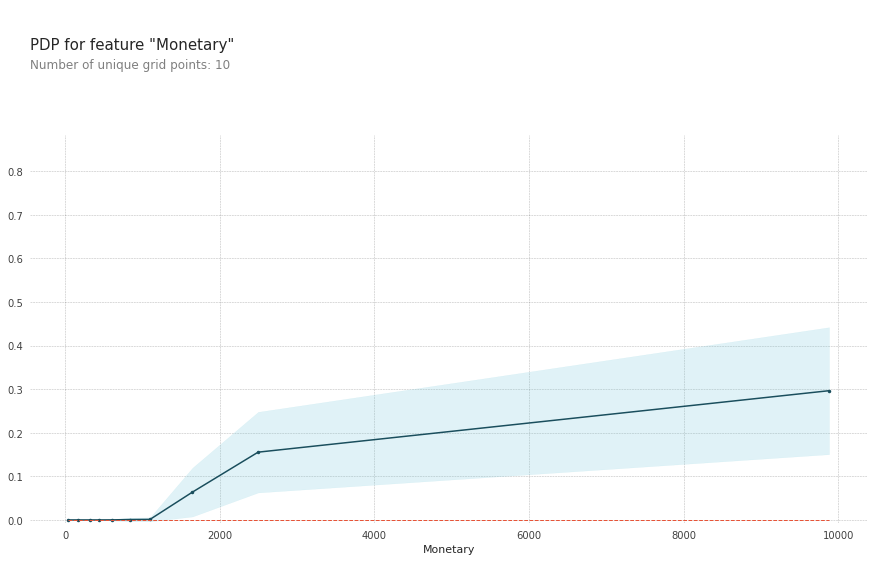

In [ ]:
# Partial Dependence Plot, 1 feature isolation

isolated = pdp_isolate(
    model=rand_clf, 
    dataset=X_val,
    model_features=X_val.columns, 
    feature='Monetary'
)

pdp_plot(isolated, feature_name='Monetary');

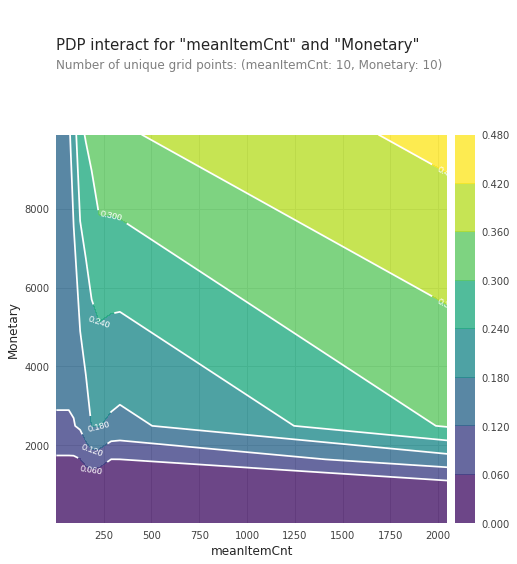

In [ ]:
# Partial Dependence Plot, 2 features interaction
# contour의 색이 밝아질수록, y축의 값이 커진다는 뜻.
# 가장 진한 보라색 영역을 보면 한 주문당 평균 상품주문수량이 적든, 많든 결제volume도 작은 경우가 있지만
# 점점 색이 밝아지는 영역이 우상향하고있고, 한 주문에 상품을 많이 주문할 때 Monetary도 큰 걸 알 수 있다.
# 주의해야 할 건, 두 feature가 상관관계에 있다는 것이지, 인과관계는 아니라는 것이다.
features = ['meanItemCnt', 'Monetary']

interaction = pdp_interact(
    model=rand_clf, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features,
)

pdp_interact_plot(interaction, plot_type='contour', 
                  feature_names=features);

In [ ]:
row = X_val.iloc[[143]]
positive_class = 1
positive_class_index = 1


pred = rand_clf_best.predict(row)[0]
pred_proba = rand_clf_best.predict_proba(row)[0, positive_class_index]
pred_proba *= 100
if pred != positive_class:
    pred_proba = 100 - pred_proba

pred_proba

93.8292762639692

In [ ]:
def explain(row_number):
    positive_class = 1
    positive_class_index = 1

    # row 값을 변환합니다
    row = X_val.iloc[[row_number]]

    # 예측하고 예측확률을 얻습니다 
    pred = rand_clf_best.predict(row)[0]
    pred_proba = rand_clf_best.predict_proba(row)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # 예측결과와 확률값을 얻습니다
    print('예측결과가 0이면 Low LTR, 1이면 High LTR을 가진 고객입니다.')
    print(f'해당 고객의 LTR 예측결과는 {pred} 입니다.')
    
    # SHAP를 추가합니다
    explainer = shap.TreeExplainer(rand_clf_best)
    shap_values = explainer.shap_values(row)

    # Fully Paid에 대한 top 3 pros, cons를 얻습니다
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0][0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=True)[:3].index
    cons = shaps.sort_values(ascending=False)[:3].index

    # 예측에 가장 영향을 준 top3
    print('\n')
    print('Positive 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # 예측에 가장 반대적인 영향을 준 요인 top1
    print('\n')
    print('Negative 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = cons if pred == positive_class else pros
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # SHAP
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value[1], 
        shap_values=shap_values[1], 
        features=row, 
        link='logit'
    )

In [ ]:
segment_df.groupby('km_label')['R_score', 'F_score', 'M_score'].mean().style.background_gradient(cmap=cm)

,R_score,F_score,M_score
km_label,,,
0,4.055128,3.267949,4.137179
1,3.840164,1.475410,1.918033
2,1.483122,1.258439,1.861814


In [ ]:
final_df.groupby('LTR_cluster')[['meanItemUnit']].agg(['mean','min', 'max','std','median'])

meanItemUnit                                       
                    mean  min         max        std     median
LTR_cluster                                                    
0              21.261231  1.0  167.333333  17.336260  17.333333
1              21.653623  1.0  185.000000  24.146782  14.436364

In [ ]:
# 그림을 좀 더 디테일하게 해석하면,
# 144번째에 있는 고객이 LTR이 높은 집단일 가능성이 72%라는뜻이며, 이렇게 예측한데에는
# 1. 구매금액이 크기 때문이다(Monetary=9,574)  : LTR이 높은 집단(1)의 평균 Monetary는 5,349, (0)은 980정도 된다.
# 2. 주문당 평균 구매 상품수량이 많기 때문이다.(meanItemCnt : 495) : LTR이 높은 집단의 주문당 평균구매수량은 약 497개, 낮은집단은 208개이다.
# 3. 주문빈도가 높았기 때문이다(Frequency=11) : 대부분의 고객들은 구매빈도가 1월 1회정도 되는데, 이 고객은 6개월동안 11번을 구매했다.
# 4. 고객집단 0(km_label=0)은 마지막 구매일자가 최근이고, 구매 빈도, 구매금액도 높은 집단이다. 이 부분도 설명력을 더했다.

explain(143)

예측결과가 0이면 Low LTR, 1이면 High LTR을 가진 고객입니다.
해당 고객의 LTR 예측결과는 1 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. Monetary : 9574.219999999998
2. M_score : 5.0
3. meanItemCnt : 495.0


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. meanItemUnit : 22.09090909090909
2. Recency : 171.0
3. R_score : 5.0


---
#### **PART6. Review**

##### **얻은 인사이트를 활용해보자. 집단별로 어떤 마케팅전략을 짤 수 있을까?**
1. 고객집단0 : 최근구매, 결제빈도도 높고 결제금액도 많은편 
=> Loyalty Programme. 고객의 리텐션 떨어지지않도록 충성도 높이는 전략 시행

2. 고객집단1 : 최근구매, 그러나 결제빈도나 결제금액이 미미함.
=> AHA moment를 경험할 수 있는 액션을 이끌어내는 전략 시행

3. 고객집단2 : 이미 떠나간 고객일 수 있음. 
=> 시선을 바로 끌 수 있으면서, 동시에 떠나가게 한 이유를 상쇄할 수 있을만한 전략 시행(ex. 할인)




In [ ]:
# 고객 집단별 평균점수
segment_df.groupby('km_label')['R_score', 'F_score', 'M_score'].mean().style.background_gradient(cmap=cm)

,R_score,F_score,M_score
km_label,,,
0,4.055128,3.267949,4.137179
1,3.840164,1.475410,1.918033
2,1.483122,1.258439,1.861814


##### **예측성능을 올리려면 어떻게 해야할까?** 

1. 1년치 데이터가 아닌, 더 충분한 양의 데이터를 활용한다.
2. RandomForest, XGBoost 말고 다른 모델을 더적용해본다. 
3. LTR이 높다고 예측하려면 어떤 feature가 필요할지 상상해보고, 고객의 인구통계학적 특성 같은 더 다양한 데이터를 활용해 feature를 만들어준다.(끝)